# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [24]:
%matplotlib inline

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
# %config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

In [26]:
# negative logL, can ignore constants since we are extremizing
def nll(a, b, x, y, dy):
    return np.sum(((y - (a * x + b)) / dy)**2)

In [27]:
# Get an estimate of what order of magnitude the parameters should be
guess_a = np.median((y[1:] - y[:-1]) / (x[1:] - x[:-1]))
guess_b = np.median(y - guess_a * x)
print(f'{guess_a = }, {guess_b = }')

guess_a = 1.459016393442623, guess_b = 151.94262295081967


In [28]:
# Using this, I can search for the parameter values that maximize logL
a_arr, b_arr = np.linspace(0.5, 2.5, 1000), np.linspace(50, 250, 1000)
min_chi2 = float('inf')
opt_a = opt_b = 0
for a in a_arr:
    for b in b_arr:
        chi2 = nll(a, b, x, y, dy)
        if chi2 < min_chi2:
            min_chi2 = chi2
            opt_a = a
            opt_b = b

print(f'{opt_a = }, {opt_b = }')

opt_a = 1.0765765765765765, opt_b = 213.36336336336336


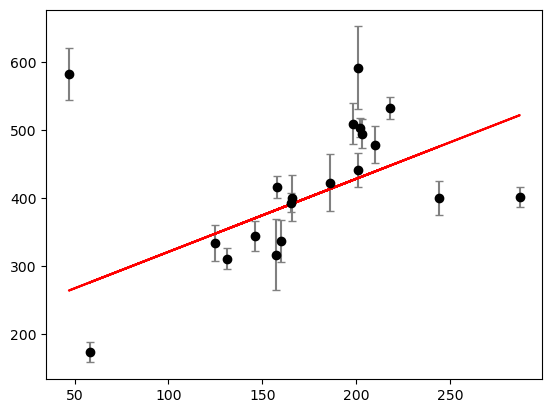

In [29]:
# Plot to compare fit
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt='o', c='Black', ecolor='Gray', capsize=3, ls='none')
ax.plot(x, opt_a * x + opt_b, c='Red')
plt.show()
plt.close(fig)

In [30]:
# Remove outliers with sigma clipping
from astropy.stats import sigma_clip
mask = sigma_clip(y - (opt_a * x + opt_b)).mask
x_clipped  = np.ma.masked_array(x,  mask).compressed()
y_clipped  = np.ma.masked_array(y,  mask).compressed()
dy_clipped = np.ma.masked_array(dy, mask).compressed()

In [31]:
# Fit model to sigma-clipped data
a_arr, b_arr = np.linspace(0.5, 2.5, 1000), np.linspace(50, 250, 1000)
min_chi2 = float('inf')
new_opt_a = new_opt_b = 0
for a in a_arr:
    for b in b_arr:
        chi2 = nll(a, b, x_clipped, y_clipped, dy_clipped)
        if chi2 < min_chi2:
            min_chi2 = chi2
            new_opt_a = a
            new_opt_b = b

print(f'{new_opt_a = }, {new_opt_b = }')

new_opt_a = 1.2627627627627627, new_opt_b = 175.32532532532534


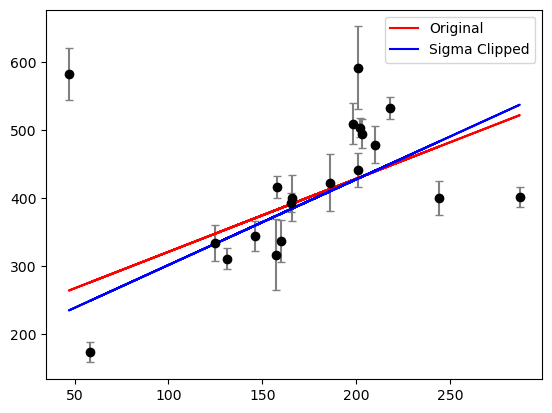

In [32]:
# Compare the two fits
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt='o', c='Black', ecolor='Gray', capsize=3, ls='none')
ax.plot(x, opt_a * x + opt_b, c='Red', label='Original')
ax.plot(x, new_opt_a * x + new_opt_b, c='Blue', label='Sigma Clipped')
ax.legend()
plt.show()
plt.close(fig)

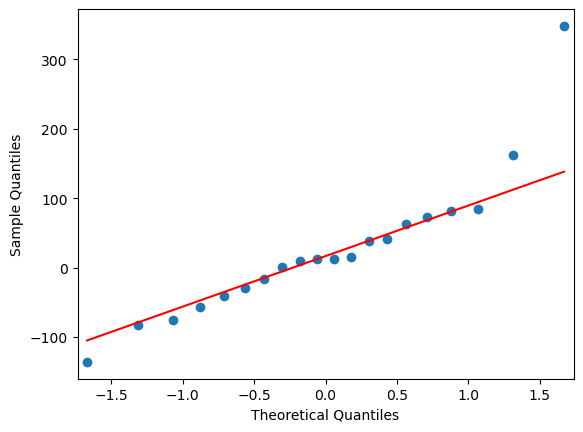

In [33]:
# Q-Q plot of residuals with line fit through quartiles
fig, ax = plt.subplots()
sm.qqplot(y - (new_opt_a * x + new_opt_b), line='q', ax=ax)
plt.show()
plt.close(fig)

In [34]:
# Negative logL with Huber loss
# I use a default of delta = 2 so that points further than 2 sigma are weighted less,
#   but changing this did not seem to significantly affect the fits
def nll_huber(a, b, x, y, dy, delta=2):
    u = (y - (a * x + b)) / dy
    return np.sum(np.where(np.abs(u) <= delta, u**2 / 2, delta * (np.abs(u) - delta / 2)))

In [35]:
# Find optimal parameters
huber_opt_a, huber_opt_b = scipy.optimize.fmin(lambda params: nll_huber(*params, x, y, dy), (guess_a, guess_b))
print(f'{huber_opt_a = }, {huber_opt_b = }')

Optimization terminated successfully.
         Current function value: 74.401087
         Iterations: 47
         Function evaluations: 91
huber_opt_a = 1.8914475698689954, huber_opt_b = 86.20584984290639


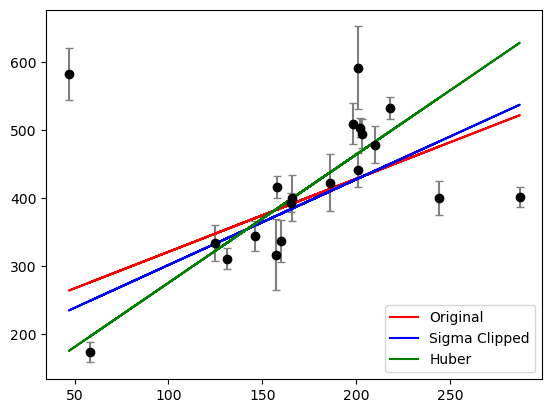

In [36]:
# Compare to previous fits
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt='o', c='Black', ecolor='Gray', capsize=3, ls='none')
ax.plot(x, opt_a * x + opt_b, c='Red', label='Original')
ax.plot(x, new_opt_a * x + new_opt_b, c='Blue', label='Sigma Clipped')
ax.plot(x, huber_opt_a * x + huber_opt_b, c='Green', label='Huber')
ax.legend()
plt.show()
plt.close(fig)

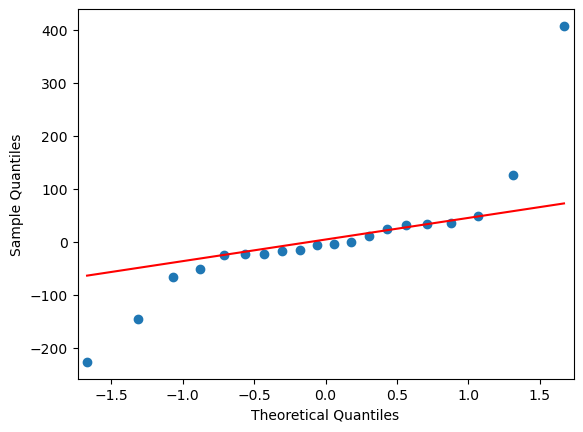

In [37]:
# Q-Q plot of residuals with Huber loss function
fig, ax = plt.subplots()
sm.qqplot(y - (huber_opt_a * x + huber_opt_b), line='q', ax=ax)
plt.show()
plt.close(fig)

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [38]:
# Read in data and separate into categories
import pandas as pd
data = pd.read_csv('Cepheids.csv')
print(data.columns)
data_LMC_F = data[(data['Cloud'] == 'LMC') & (data['Mode'] == 'F')]
data_LMC_1 = data[(data['Cloud'] == 'LMC') & (data['Mode'] == '1')]
data_SMC_F = data[(data['Cloud'] == 'SMC') & (data['Mode'] == 'F')]
data_SMC_1 = data[(data['Cloud'] == 'SMC') & (data['Mode'] == '1')]
datasets = [data_LMC_F, data_LMC_1, data_SMC_F, data_SMC_1]

Index(['name', 'RA0', 'Decl0', 'Mode', 'Cloud', 'W', 'logP1', 'VI'], dtype='object')


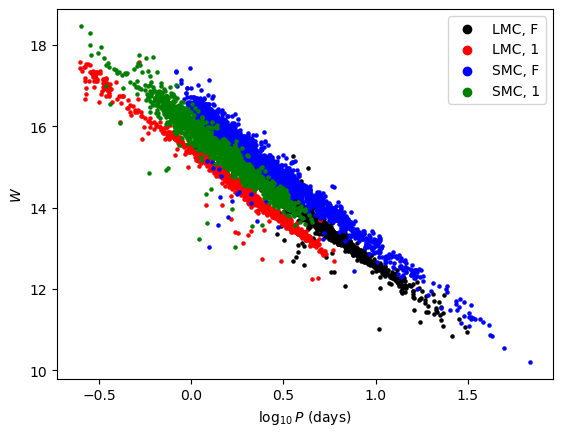

In [39]:
# Plot data
fig, ax = plt.subplots()
ax.set_xlabel(r'$\log_{10}P$ (days)')
ax.set_ylabel('$W$')
colors = ['Black', 'Red', 'Blue', 'Green']
labels = ['LMC, F', 'LMC, 1', 'SMC, F', 'SMC, 1']
for (color, label) in zip(colors, labels):
    ax.scatter([], [], c=color, label=label)
for (color, dataset) in zip(colors, datasets):
    ax.scatter(dataset['logP1'], dataset['W'], s=5, c=color)
ax.legend()
plt.show()
plt.close(fig)

In [40]:
# Fit lines to these samples
fit_params_set = [scipy.optimize.fmin(lambda params: nll_huber(*params, dataset['logP1'], dataset['W'], np.std(dataset['W'])), (-4, 16)) for dataset in datasets]
print(fit_params_set)

Optimization terminated successfully.
         Current function value: 35.133458
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 16.304901
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 58.022678
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 65.324341
         Iterations: 33
         Function evaluations: 65
[array([-3.3258192 , 15.89284136]), array([-3.43226529, 15.38396909]), array([-3.45552832, 16.48171475]), array([-3.61804328, 15.9640973 ])]


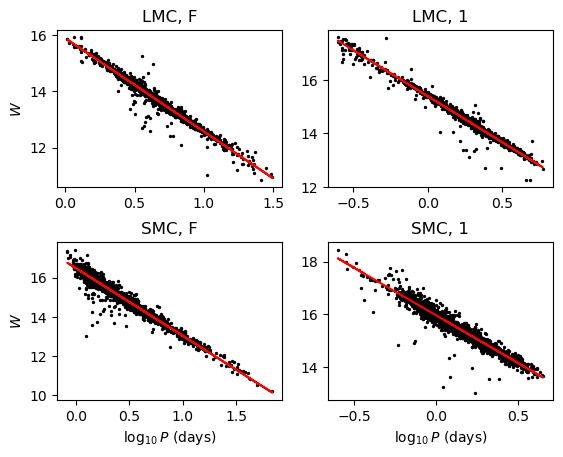

In [41]:
# Plof the fits
fits = [(fit_params[0] * dataset['logP1'] + fit_params[1]) for (fit_params, dataset) in zip(fit_params_set, datasets)]

fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.35)
axes = axes.reshape(4)
axes[0].set_ylabel('$W$')
axes[2].set_ylabel('$W$')
axes[2].set_xlabel(r'$\log_{10}P$ (days)')
axes[3].set_xlabel(r'$\log_{10}P$ (days)')
for (ax, dataset, fit, label) in zip(axes, datasets, fits, labels):
    ax.set_title(label)
    ax.scatter(dataset['logP1'], dataset['W'], s=2, c='Black')
    ax.plot(dataset['logP1'], fit, c='Red')
plt.show()
plt.close(fig)

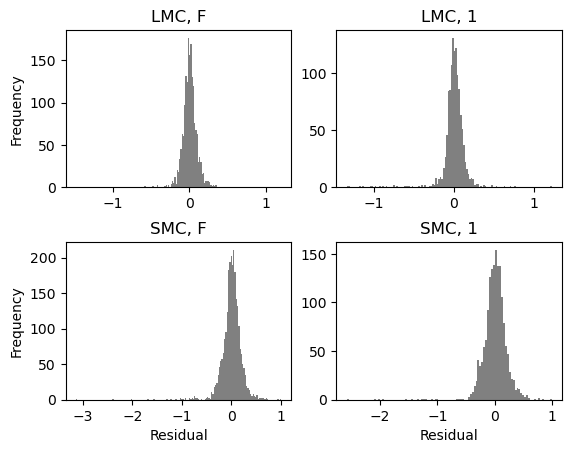

In [42]:
# Plot distributions of residuals
residuals = [dataset['W'] - fit for (dataset, fit) in zip(datasets, fits)]

fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.35)
axes = axes.reshape(4)
axes[0].set_ylabel('Frequency')
axes[2].set_ylabel('Frequency')
axes[2].set_xlabel('Residual')
axes[3].set_xlabel('Residual')
for (ax, residual, label) in zip(axes, residuals, labels):
    ax.set_title(label)
    ax.hist(residual, bins='fd', color='Gray')
plt.show()
plt.close(fig)


The residuals look roughly normally distributed, although it is difficult to tell accurately from just these plots. The SMC histograms seem to be slightly asymmetric, which indicates that the model is not a perfect description of the data.

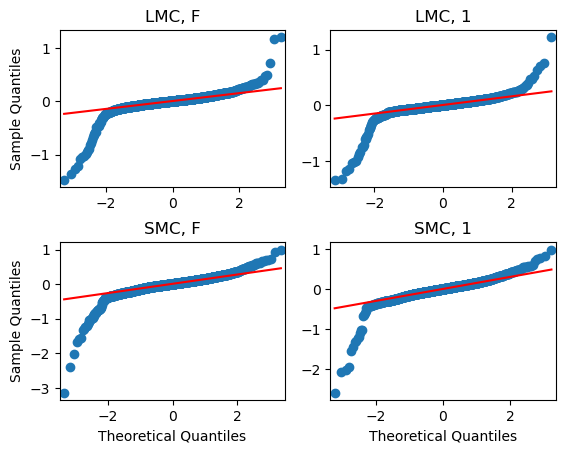

In [43]:
# Q-Q plots
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.35)
axes = axes.reshape(4)
for (ax, residual, label) in zip(axes, residuals, labels):
    ax.set_title(label)
    sm.qqplot(residual, line='q', ax=ax)
for axis in [axes[0].xaxis, axes[1].xaxis, axes[1].yaxis, axes[3].yaxis]:
    axis.label.set_visible(False)
plt.show()
plt.close(fig)

The Q-Q plots show that the residuals are not normally distributed, and have weaker and more asymmetric tails than a normal distribution.

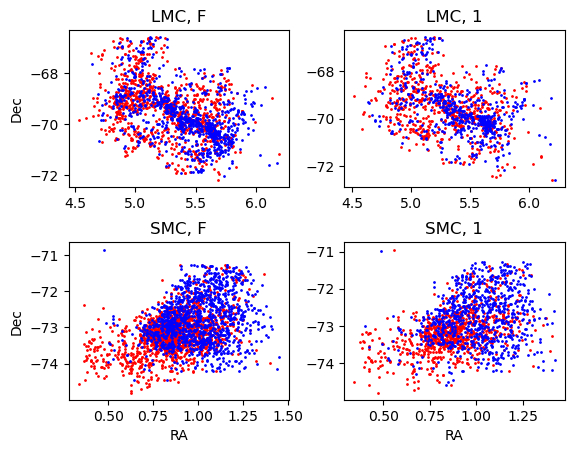

In [44]:
# Plot of residuals with RA and Dec
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.25, hspace=0.35)
axes = axes.reshape(4)
axes[0].set_ylabel('Dec')
axes[2].set_ylabel('Dec')
axes[2].set_xlabel('RA')
axes[3].set_xlabel('RA')
for (ax, dataset, residual, label) in zip(axes, datasets, residuals, labels):
    ax.set_title(label)
    ax.scatter(dataset['RA0'][residual >= 0], dataset['Decl0'][residual >= 0], c='Red',  s=1)
    ax.scatter(dataset['RA0'][residual < 0],  dataset['Decl0'][residual < 0],  c='Blue', s=1)
plt.show()
plt.close(fig)

Red points have positive residual and blue points have negative residual.

In the LMC, points of negative residual are mostly clusted around a central line, while points of positive residual appear to be more spread out.

In the SMC, there are more points of positive than negative residual at lower RA. Points of negative residual are not clusted around a central line as they are in the LMC.

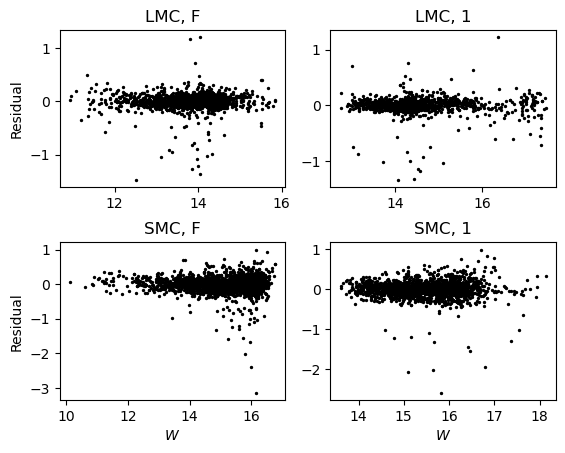

In [45]:
# Plot of residuals against fitted W
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.35)
axes = axes.reshape(4)
axes[0].set_ylabel('Residual')
axes[2].set_ylabel('Residual')
axes[2].set_xlabel('$W$')
axes[3].set_xlabel('$W$')
for (ax, fit, residual, label) in zip(axes, fits, residuals, labels):
    ax.set_title(label)
    ax.scatter(fit, residual, c='Black', s=2)
plt.show()
plt.close()

For LMC modes F/1, most of the strong outliers have fitted W~13-15, and there are more severe negative outliers than positive.

For SMC mode F, the strongest outliers have fitted W~16, and the largest negative residuals are much larger than the largest positive residuals.

For SMC mode 1, the negative outliers are spread across fitted W~15-17.5, but the negative residuals are again larger than the positive residuals.

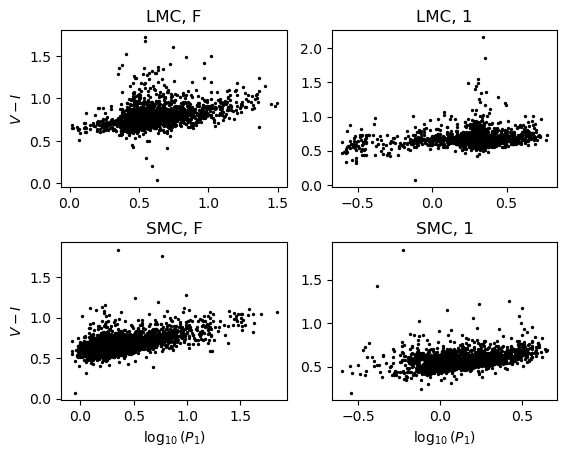

In [46]:
# Plot of logP1 against V - I
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.35)
axes = axes.reshape(4)
axes[0].set_ylabel('$V-I$')
axes[2].set_ylabel('$V-I$')
axes[2].set_xlabel(r'$\log_{10}(P_{1})$')
axes[3].set_xlabel(r'$\log_{10}(P_{1})$')
for (ax, dataset, label) in zip(axes, datasets, labels):
    ax.set_title(label)
    ax.scatter(dataset['logP1'], dataset['VI'], c='Black', s=2)
plt.show()
plt.close()

There is also a correlation between V-I and logP1, although the slope of a line through the data would be small. There appears to be a similar level of scatter to that in the logP1 vs W plot. The outliers are biased towards larger V-I, which makes sense since -(V-I) appears in the definition of W.